# Chen and Dickens (2009), Figures 1 and 2

Reproduced by Dieter Werthmüller ([@prisae](https://github.com/prisae)).

> **Chen, J., and T. A. Dickens, 2009**  
> Effects of uncertainty in rock‐physics models on reservoir parameter estimation using seismic amplitude variation with > angle and controlled‐source electromagnetics data.  
> Geophysical Prospecting, volume 57, pages 61-74; DOI: [10.1111/j.1365-2478.2008.00721.x](https://doi.org/10.1111/j.1365-2478.2008.00721.x).

### Requirements
- `NumPy`
- `SciPy`
- `IPython`
- `Jupyter`
- `matplotlib`
- `pymc3`

**NOTE:** I created these scripts during my PhD, somewhen in 2011 (if you are interested in my thesis you can find it [here](https://werthmuller.org/research), it comes with all source code, unfortunately without the real data due to copyrights). It was still my early time with Python, so don't be too harsh ;). Many things would probably be included in `bruges`, `welly`, or other packages by now, I don't know. The only thing I did at this point was to extract the required functions and translate them from Python 2 to Python 3 (particularly move from `pymc` to `pymc3`).

In [1]:
import numpy as np
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from pymc import MCMC, Uniform, Gamma, deterministic

import xuncertainty

In [2]:
# Plot-style adjustments
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

**Note:** There is a typo in Equation (1) of Chen and Dickens.

In the paper it reads like this

$$
  \frac{S_w^{-m}}{\sqrt{r}} =
  \frac{\varphi^{0.5n}}{\sqrt{r_b}} + \frac{c^{1-0.5c}}{\sqrt{r_c}} \ ,
$$

but the correct version includes the square-root of water saturation,

$$
  \frac{\sqrt{S_w^{-m}}}{\sqrt{r}} =
  \frac{\varphi^{0.5n}}{\sqrt{r_b}} + \frac{c^{1-0.5c}}{\sqrt{r_c}} \ .
$$

Jinsong Chen kindly confirmed me the typo in an email-correspondence in 2011.

## Figure 1

### Calculation

In [3]:
# Parameters
data = {
    's_w': np.array([0.1]),          # water saturation
    'vsh': np.array([0.1]),          # shale content
    'por': np.array([0.32]),         # porosity
    'rho_f': np.array([0.16]),       # brine resistivity
    'rho_s': np.array([0.50]),       # shale resistivity
    'm_e': np.array([2.]),           # m-exponent
    'n_e': np.array([2.]),           # n-exponent
}

nrs = 1000                         # number of samples for vectors

# Figure 1a - water saturation
s_w  = np.linspace(0.01, 1, nrs) # water saturation
data2 = dc(data)
data2['s_w'] = s_w
rho_ws = xuncertainty.rho_poup(data2)

# Figure 1b - shale content
c_c  = np.linspace(0, 1, nrs)    # shale content
data3 = dc(data)
data3['vsh'] = c_c
rho_sc = xuncertainty.rho_poup(data3)

# Figure 1c - porosity
por  = np.linspace(0, .4, nrs)   # porosity
data4 = dc(data)
data4['por'] = por
rho_po = xuncertainty.rho_poup(data4)

### Plot

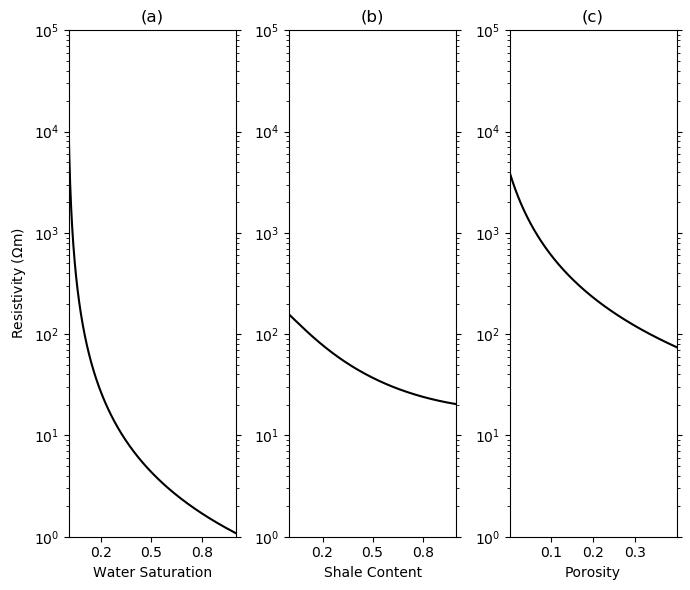

In [4]:
plt.figure(figsize=(7, 6))
plt.ylim([1, 100000])

plt.subplot(131)
plt.title('(a)')
plt.xlabel("Water Saturation")
plt.ylabel("Resistivity ($\Omega$m)")
plt.semilogy(s_w, rho_ws, 'k-')
plt.ylim([1, 100000])
plt.xlim([min(s_w), max(s_w)])
plt.xticks([0.2, 0.5, 0.8], ('0.2', '0.5', '0.8'))
plt.gca().yaxis.set_ticks_position('both')

plt.subplot(132)
plt.title('(b)')
plt.xlabel("Shale Content")
plt.semilogy(c_c, rho_sc, 'k-')
plt.ylim([1, 100000])
plt.xlim([0, 1])
plt.xticks([0.2, 0.5, 0.8], ('0.2', '0.5', '0.8'))
plt.gca().yaxis.set_ticks_position('both')

plt.subplot(133)
plt.title('(c)')
plt.xlabel("Porosity")
plt.semilogy(por, rho_po, 'k-')
plt.ylim([1, 100000])
plt.xlim([0, .4])
plt.xticks([0.1, 0.2, 0.3], ('0.1', '0.2', '0.3'))
plt.gca().yaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

Figure 1 An example showing the relationship between electrical resistivity and water saturation, shale content and porosity, where $r_b$ = 0.16 $\Omega\,$m, $r_c$ = 0.50 $\Omega\,$m and $m$ = $n$ = 2. In Fig. 1(a), shale content is 0.1 and porosity is 0.32, in Fig. 1(b), water saturation is 0.1 and porosity is 0.32 and in Fig. 1(c), both shale content and water saturation are 0.1.

### Original Figure 1

![title](Figure1.jpg)

## Figure 2

### Calculation

In [5]:
def model_param(prce, data):
    """ Chen and Dickens (2007), Geophysics """
    cdDAT = dc(data)

    #  # USED PARAMETER VALUES #  #
    cdDAT['rho_f'] = Uniform('rho_b_t', lower=(1.-prce)*data['rho_f'],
                             upper=(1.+prce)*data['rho_f'])
    cdDAT['rho_s'] = Uniform('rho_c_t', lower=(1.-prce)*data['rho_s'],
                             upper=(1.+prce)*data['rho_s'])
    cdDAT['m_e']   = Uniform('m_exp_t', lower=(1.-prce)*data['m_e'],
                             upper=(1.+prce)*data['m_e'])
    cdDAT['n_e']   = Uniform('n_exp_t', lower=(1.-prce)*data['n_e'],
                             upper=(1.+prce)*data['n_e'])

    # POUPON MODEL
    @deterministic(plot=False)
    def poupon(cdDAT=cdDAT):
        """ Poupon and Leveaux (1971), "Indonesia formula" """
        return xuncertainty.rho_poup(cdDAT)

    r_mode = poupon
    alpha = 1/prce**2
    beta = (alpha-1)/r_mode # beta = 1/beta_cd; beta_cd = r_mode/(alpha-1)

    cd_ = Gamma('cd_', alpha=alpha, beta=beta)

    return locals()

# "True" value
tval = xuncertainty.rho_poup(data)

# Calculate MCMC
res = {}
prob = {}
percentage = np.array([1./100, 3./100, 5./100])
for i, per in enumerate(percentage):
    M = MCMC(model_param(per, data))
    M.sample(10000, 0, 1)

    mdata = M.trace('cd_')[:, 0]
    pdf  = xuncertainty.GKDE(mdata)
    res[i]  = pdf.bins(100)
    prob[i] = pdf.adband(2)(res[i])

 [-----------------100%-----------------] 10000 of 10000 complete in 2.1 sec

### Plot

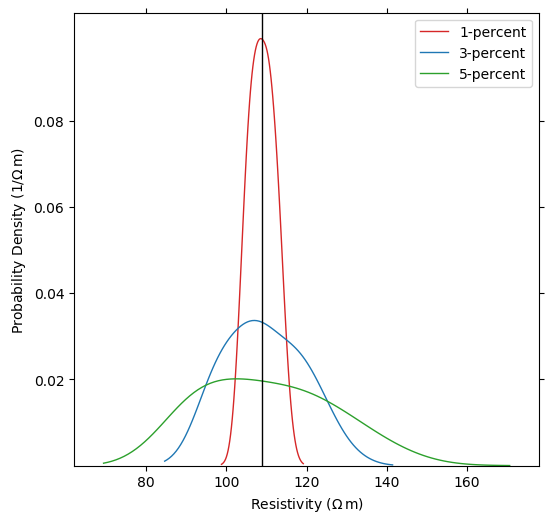

In [6]:
fig = plt.figure(figsize=(6, 6))

lc = ['C3', 'C0', 'C2']

for i in range(3):
    plt.plot(res[i], prob[i], lc[i], lw=1, label=str(int(100*percentage[i]))+'-percent')

plt.axvline(tval, linewidth=1, color='k')

plt.xlabel('Resistivity ($\Omega\,$m)')
plt.ylabel('Probability Density (1/$\Omega\,$m)')
plt.axis([62, 178, 0, .105])
plt.yticks([0.02, 0.04, 0.06, 0.08])
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.legend()
plt.show()

**Figure 2** Conditional probability distributions given water saturation (0.1), shale content (0.1) and porosity (0.32) as brine resistivity, shale resistivity and the exponential components of water saturation and porosity in the Poupon model vary uniformly around their corresponding true values, where the red, blue and green curves are the results when the relative errors are 1, 3 and 5%, respectively.

### Original Figure 2
![title](Figure2.jpg)